# Gas Predict

Predict gas fees for the next X hours to be able to judge how likely certain lows are going to happen.

We're especially interested in predicting the next low gas fees as well as their probabilities.

To download the data, we use `run-download.sh`.

### Read Data

In [1]:
import json

data_file = "data/data.json"

with open(data_file,"r") as f:
    data_json = json.load(f)

In [2]:
import numpy as np

In [3]:
# We use the past-window 15%-quantile to estimate the future minimum
estimateQuantile = 0.15

In [4]:
# Convert to a format where we have an array with fields:
# blocknr, day in week, hour in day, minute in hour, second in minute

# Essentially, given a few days of gas prices, we want to predict how it's going to continue.

oN = len(data_json)
print(oN,"blocks")

M = 6
# fields: blockr, gas, timestamp, median over future-window, minimum over future-window, {estimateQuantile}-quantile over past-window
# each block will be centered in its window and not preceding it. this is, because we want all these
# rolling averages to have the spikes etc. on the same block

# We want to use 24hours as our window-size to see what the probable 24h minimum is going to be
day_as_minutes = 60 * 24
window_size = day_as_minutes *60//12 # x minutes = x*60 seconds = x*60/12 blocks
odata = np.zeros((oN, M),dtype=np.int64)

i = 0
for k, v in data_json.items():
    fee = int(v["fee"])
    odata[i] = np.array([k,fee, v["t"], 0, 0, 0],dtype=np.int64)
    i = i + 1
    
# sort by time (newest last)
odata = odata[odata[:,0].argsort()]

print("Calculating rolling windows...")
for i in range(oN):
    if i < window_size:
        continue
    # future windows
    iPast = i - window_size
    odata[iPast,3] = np.median(odata[(i-window_size):i,1])
    odata[iPast,4] = np.min(odata[(i-window_size):i,1])
    
    # past windows
    odata[i,5] = np.quantile(odata[(i-window_size):i,1], estimateQuantile)
    
print("Done.")
    
print(odata[:12])
print(odata[(oN-12):])

1017546 blocks
Calculating rolling windows...
Done.
[[  16083440         13 1669818995         11          8          0]
 [  16083441         13 1669819007         11          8          0]
 [  16083442         14 1669819019         11          8          0]
 [  16083443         14 1669819031         11          8          0]
 [  16083444         15 1669819043         11          8          0]
 [  16083445         14 1669819055         11          8          0]
 [  16083446         15 1669819067         11          8          0]
 [  16083447         14 1669819079         11          8          0]
 [  16083448         14 1669819091         11          8          0]
 [  16083449         14 1669819103         11          8          0]
 [  16083450         14 1669819115         11          8          0]
 [  16083451         14 1669819127         11          8          0]]
[[  17100974         37 1682155511          0          0         30]
 [  17100975         35 1682155523          0     

In [5]:
# cut head and tail, since moving windows don't make sense there
oN = oN - window_size * 2
odata = odata[window_size:,:] # remove head
odata = odata[:oN,:] # remove tail

In [6]:
print(odata.shape)

(1003146, 6)


Rather than predicting the gas price, it makes more sense to create moving median, minimum and x quantile (e.g. 15%%) and predict that.
Otherwise the high spikes in gas price will dominate the predictions even though we're rather interested in the lows.

---

## Gas Price with moving median/minimun/quantile(15%)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

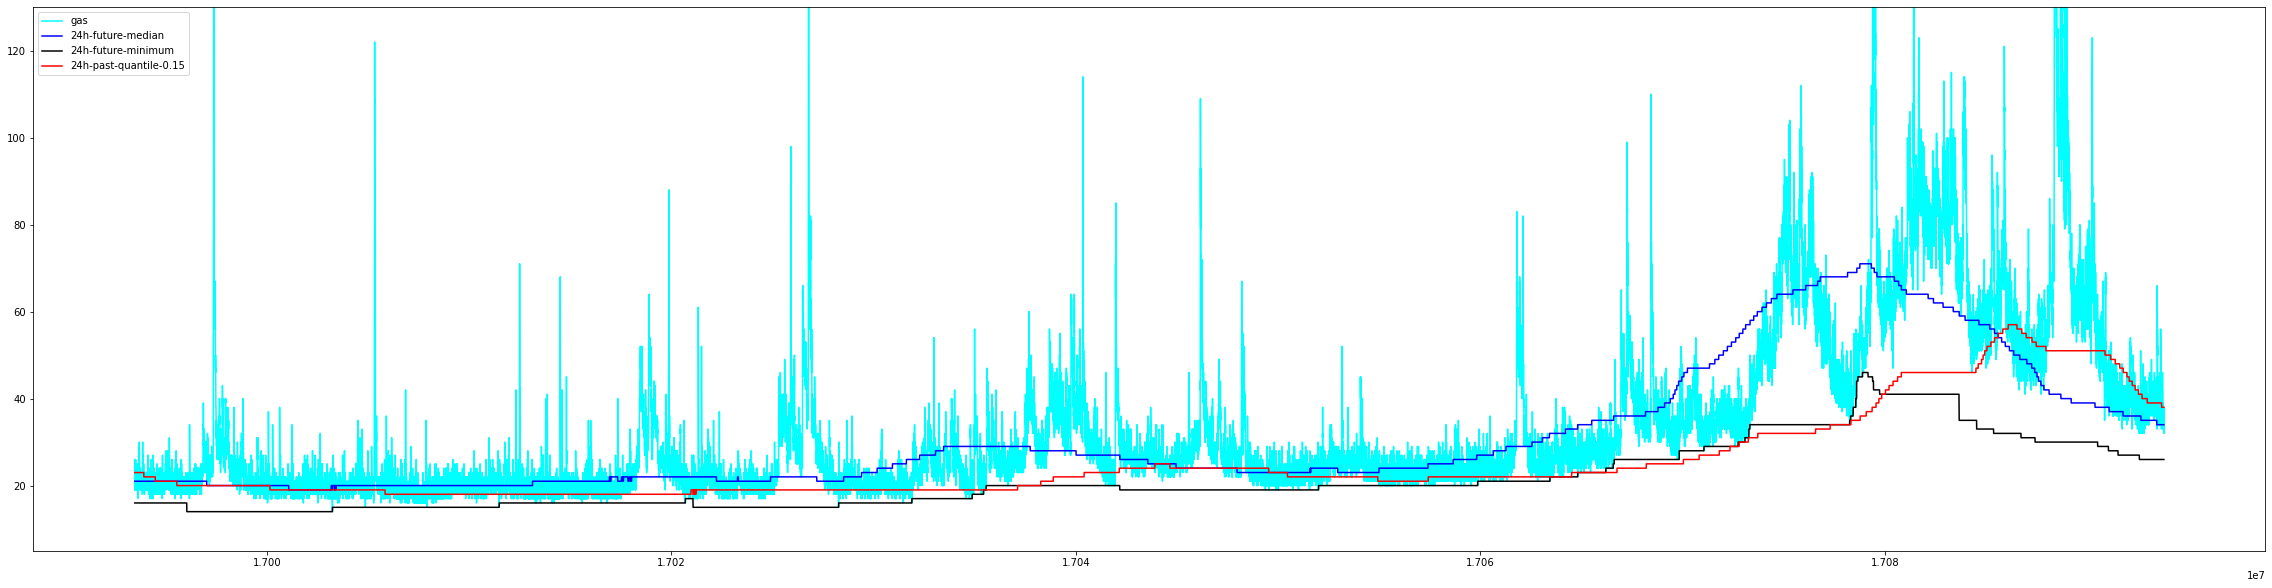

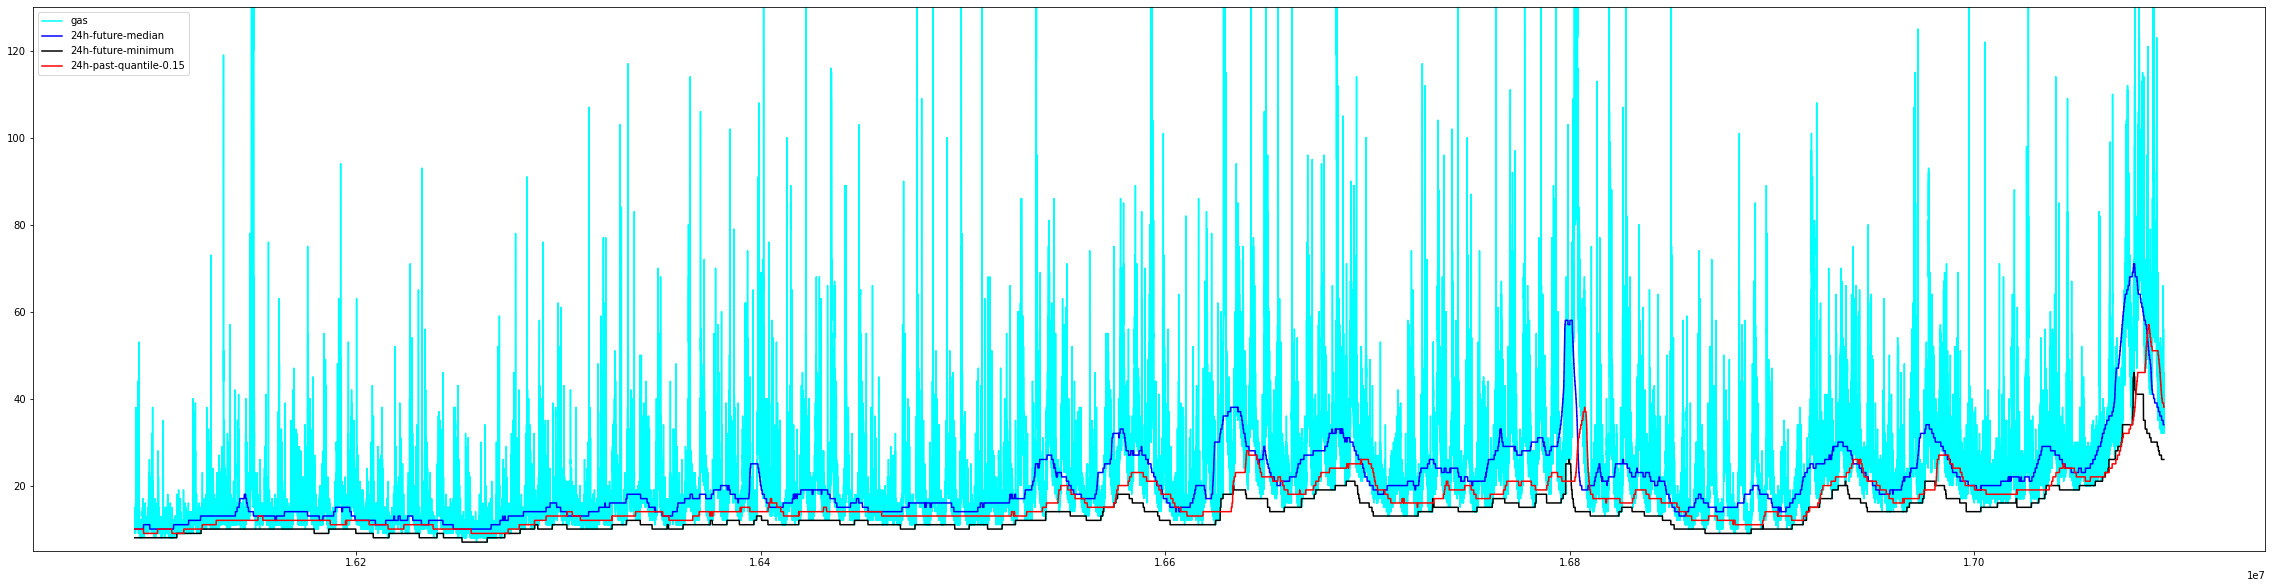

In [15]:
showN = oN // 10

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1],"cyan",label="gas")
plt.plot(odata[-showN:,0],odata[-showN:,3],"blue",label="24h-future-median")
plt.plot(odata[-showN:,0],odata[-showN:,4],"black",label="24h-future-minimum")
plt.plot(odata[-showN:,0],odata[-showN:,5],"red",label="24h-past-quantile-" + str(estimateQuantile))
plt.ylim(5,130)
plt.legend(loc="upper left")
plt.show()

showN = oN

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1],"cyan",label="gas")
plt.plot(odata[-showN:,0],odata[-showN:,3],"blue",label="24h-future-median")
plt.plot(odata[-showN:,0],odata[-showN:,4],"black",label="24h-future-minimum")
plt.plot(odata[-showN:,0],odata[-showN:,5],"red",label="24h-past-quantile-" + str(estimateQuantile))
plt.legend(loc="upper left")
plt.ylim(5,130)
plt.show()


## Forcasting

Used this tutorial/template:
https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

PYAF: https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b


In [16]:
# test train split
import pandas as pd

data = pd.DataFrame(odata[:, [0,1,3,4,5]]) # keep only mid-window-quantile and live-quantile
cols = ["BlockNr", "Gas","Median-Future","Minimum-Future","Quantile-Past"]
xVar = "Quantile-Past"
yVar = "Minimum-Future"
data.columns = cols

actualSavings = "actualSavings"
optSavings = "optSavings"

print("optimal savings")
data[optSavings] = data["Gas"] - data[yVar]
print(data[optSavings].describe())
print("")
print(f"Saves {data[optSavings].mean():.1f} +/-{data[optSavings].std():.0f} gas per block")

print("")
print("")

print(str(estimateQuantile) + "-quantile savings")
data[actualSavings] = data["Gas"] - data[xVar]
print(data[actualSavings].describe())
print("")
print(f"Saves {data[actualSavings].mean():.1f} +/-{data[actualSavings].std():.0f} gas per block")

print("")
print("")

# todo. why does flipping the < not return 1 - x?
print(f"Only in {(data[xVar] < data[yVar]).sum() / len(data) * 100:.1f}% of the blocks, the predicted gas price wouldn't occur in the next 24 hours.")
print("")

print(f"The actual savings are {data[actualSavings].mean()/data[optSavings].mean()*100:.0f}% as good as the optimal savings")

optimal savings
count    1.003146e+06
mean     1.013582e+01
std      1.627652e+01
min      0.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.200000e+01
max      7.950000e+02
Name: optSavings, dtype: float64

Saves 10.1 +/-16 gas per block


0.15-quantile savings
count    1.003146e+06
mean     7.029326e+00
std      1.606111e+01
min     -1.700000e+01
25%      0.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      7.990000e+02
Name: actualSavings, dtype: float64

Saves 7.0 +/-16 gas per block


Only in 2.8% of the blocks, the predicted gas price wouldn't occur in the next 24 hours.

The actual savings are 69% as good as the optimal savings


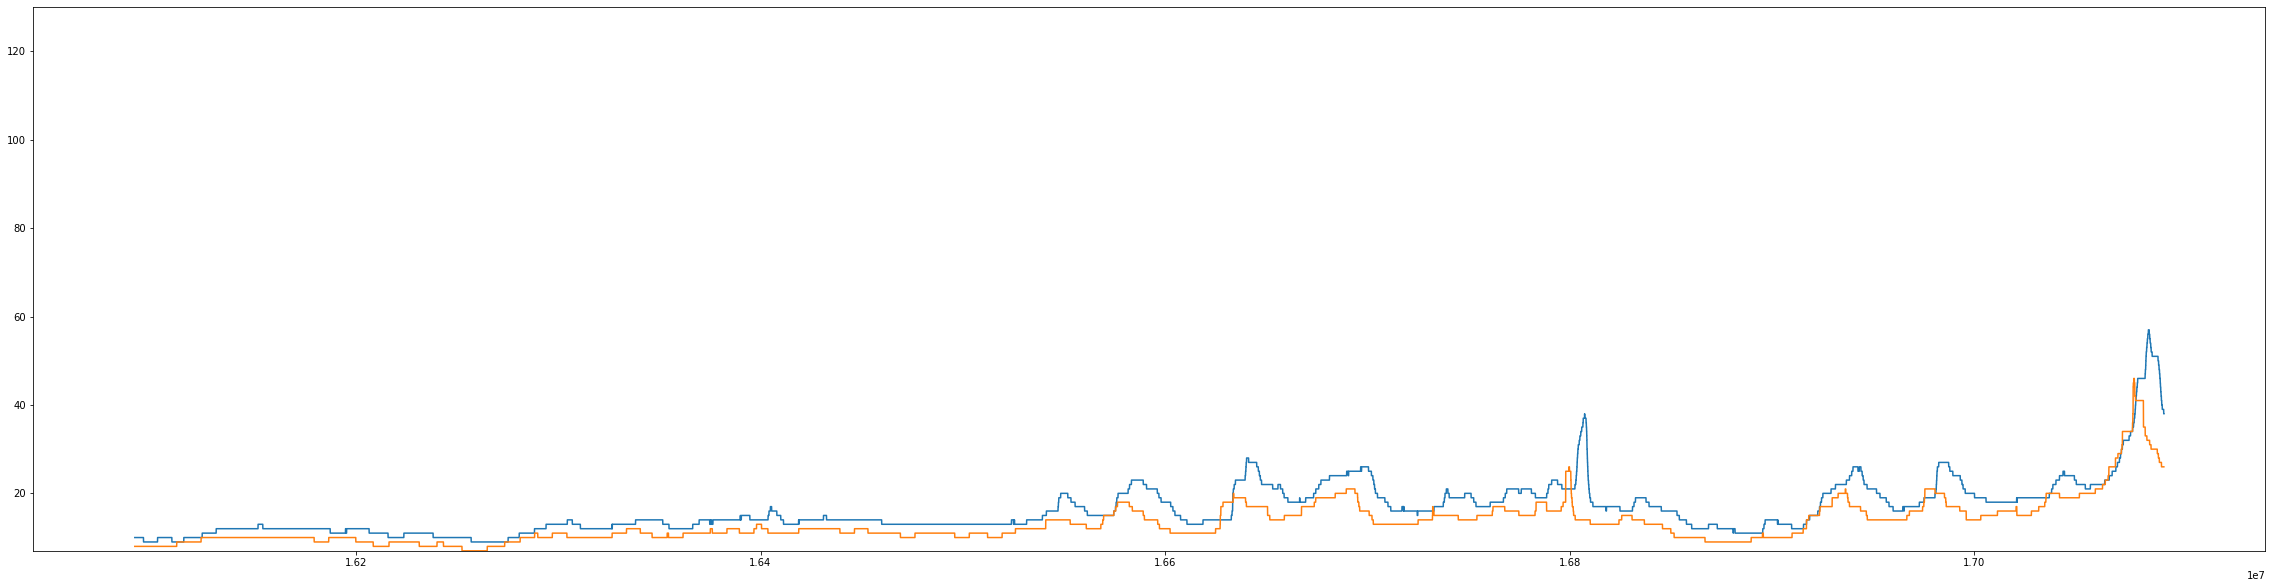

In [17]:
plt.figure(figsize=(40,10))
plt.plot(data["BlockNr"],data[xVar])
plt.plot(data["BlockNr"],data[yVar])
plt.ylim(7,130)
plt.show()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003146 entries, 0 to 1003145
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   BlockNr         1003146 non-null  int64
 1   Gas             1003146 non-null  int64
 2   Median-Future   1003146 non-null  int64
 3   Minimum-Future  1003146 non-null  int64
 4   Quantile-Past   1003146 non-null  int64
 5   optSavings      1003146 non-null  int64
 6   actualSavings   1003146 non-null  int64
dtypes: int64(7)
memory usage: 53.6 MB


In [19]:
data.head()

,BlockNr,Gas,Median-Future,Minimum-Future,Quantile-Past,optSavings,actualSavings
0,16090640,11,10,8,10,3,1
1,16090641,11,10,8,10,3,1
2,16090642,11,10,8,10,3,1
3,16090643,11,10,8,10,3,1
4,16090644,11,10,8,10,3,1
